<a href="https://colab.research.google.com/github/prince90038/corona-prediction/blob/main/experiment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Covid-19 Classification Based On Chest X-Ray#

Mount the Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzip the Dataset File

In [2]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/COVID-19 Radiography Database.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


Importing the Libraries

In [3]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.preprocessing.image import ImageDataGenerator
import time
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
import cv2
import os
import random
import shutil
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools
from sklearn.metrics import classification_report

#Creating Custom Dataset#

In [4]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))
    os.mkdir(os.path.join(root_dir, 'train'))
    os.mkdir(os.path.join(root_dir,'validation'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))
        os.mkdir(os.path.join(root_dir, 'validation', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 315)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)
    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 10)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'validation', c, image)
            shutil.move(source_path, target_path)     


     
    for c in class_names:
        shutil.move(os.path.join(root_dir, c), os.path.join(root_dir, 'train'))

#Data Pre-processing Phase#

In [5]:
TrainingImagePath='/content/COVID-19 Radiography Database/train'
TestImagePath='/content/COVID-19 Radiography Database/test'
batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range = 0.1,
        zoom_range = 0.1,
        horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
        TrainingImagePath,
        target_size = (256, 256),
        batch_size = batch_size,
        class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(
        TestImagePath,
        target_size = (256, 256),
        batch_size = batch_size,
        shuffle = False,
        class_mode = 'categorical')

test_set.class_indices

Found 2854 images belonging to 3 classes.
Found 945 images belonging to 3 classes.


{'covid': 0, 'normal': 1, 'viral': 2}

In [6]:
TrainClasses = training_set.class_indices

labels = {}
for faceName, faceValue in TrainClasses.items():
    labels[faceValue] = faceName

print('Mapping of Dataset\n')
for key, value in labels.items():
    print(str(key) + " --> " + value)

OutputNeurons = len(labels)
print('\nRequired Output Neurons:{}'.format(OutputNeurons))

Mapping of Dataset

0 --> covid
1 --> normal
2 --> viral

Required Output Neurons:3


#CNN Model#

Initializing the Convolutional Neural Network

In [7]:
cnn = Sequential()

#Step:1#

#Convolution#


Adding the first layer of CNN

In [8]:
cnn.add(Convolution2D(32, kernel_size=(5, 5), strides=(1, 1), input_shape=(256,256,3), activation='relu'))

#Step:2#
#MAX Pooling#

In [9]:
cnn.add(MaxPool2D(pool_size=(2,2)))

#Addtional Layer of Convulution# 

In [10]:
cnn.add(Convolution2D(64, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2)))

In [11]:
cnn.add(Convolution2D(128, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2)))

In [12]:
cnn.add(Convolution2D(256, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2)))

#Step:3# 
#Flattening#

In [13]:
cnn.add(Flatten())

#Step:4#
#Fully Connected Neural Network#

In [14]:
cnn.add(Dense(150, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(75, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(OutputNeurons, activation='softmax'))

#Compiling the CNN#

In [15]:
cnn.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])

#Start Training the Model#

In [16]:
StartTime=time.time()
classifier = cnn.fit(
                    training_set,
                    # steps_per_epoch=160,
                    epochs=50,
                    validation_data=test_set,
                    validation_steps=(765//batch_size))

EndTime = time.time()
print()
print("*"*137)
print('Total Time Taken to Train the Model: ', round((EndTime-StartTime)/60), 'Minutes')

Epoch 1/50
90/90 [==============================] - 119s 821ms/step - loss: 1.0986 - accuracy: 0.3660 - val_loss: 0.5552 - val_accuracy: 0.8505
Epoch 2/50
90/90 [==============================] - 75s 832ms/step - loss: 0.6559 - accuracy: 0.7207 - val_loss: 0.3721 - val_accuracy: 0.8777
Epoch 3/50
90/90 [==============================] - 75s 830ms/step - loss: 0.4778 - accuracy: 0.8101 - val_loss: 0.2881 - val_accuracy: 0.9090
Epoch 4/50
90/90 [==============================] - 73s 813ms/step - loss: 0.4063 - accuracy: 0.8569 - val_loss: 0.2371 - val_accuracy: 0.9280
Epoch 5/50
90/90 [==============================] - 73s 813ms/step - loss: 0.3676 - accuracy: 0.8740 - val_loss: 0.2280 - val_accuracy: 0.9266
Epoch 6/50
90/90 [==============================] - 73s 811ms/step - loss: 0.3288 - accuracy: 0.8807 - val_loss: 0.1477 - val_accuracy: 0.9552
Epoch 7/50
90/90 [==============================] - 73s 809ms/step - loss: 0.3509 - accuracy: 0.8706 - val_loss: 0.1802 - val_accuracy: 0.937

Confussion Matrix

#Training and Validation Accuracy Graph#

[]

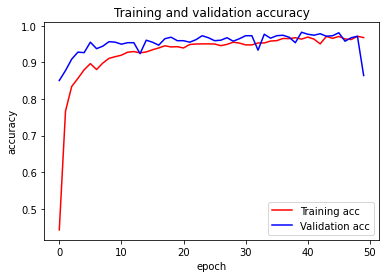

In [17]:
acc = classifier.history['accuracy']
val_acc = classifier.history['val_accuracy']
loss = classifier.history['loss']
val_loss = classifier.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.plot()

#Training and Validation Loss Graph#

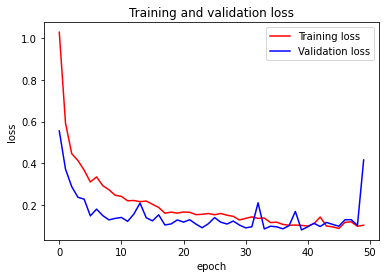

In [18]:
acc = classifier.history['accuracy']
val_acc = classifier.history['val_accuracy']
loss = classifier.history['loss']
val_loss = classifier.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()


#Final Prediction#

AttributeError: ignored

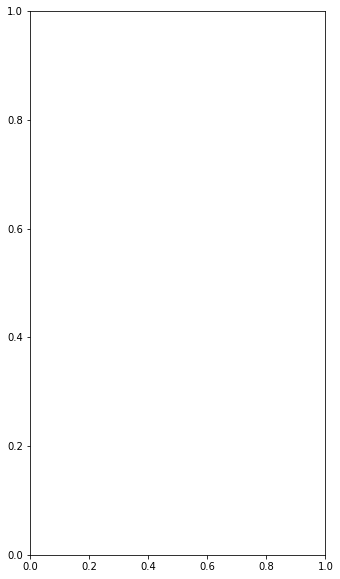

In [19]:
fig = plt.figure(figsize=(18, 10))

rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
ImagePath = '/content/COVID-19 Radiography Database/validation/covid/COVID-19 (1056).png'
Image = cv2.imread(ImagePath)
test_image = image.load_img(ImagePath,target_size=(256, 256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)
result = cnn.predict(test_image)

plt.imshow(Image)
col = 'green' if labels[0] == labels[np.argmax(result)] else 'red'
plt.xlabel(labels[0])
plt.ylabel(labels[np.argmax(result)], color=col)

fig.add_subplot(rows, columns, 2)

ImagePath = '/content/COVID-19 Radiography Database/validation/normal/NORMAL (291).png'
test_image = image.load_img(ImagePath,target_size=(256, 256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)
result = cnn.predict(test_image)
Image = cv2.imread(ImagePath)

plt.imshow(Image)
col = 'green' if labels[1] == labels[np.argmax(result)] else 'red'
plt.xlabel(labels[1])
plt.ylabel(labels[np.argmax(result)], color=col)

fig.add_subplot(rows, columns, 3)
ImagePath = '/content/COVID-19 Radiography Database/validation/viral/Viral Pneumonia (104).png'
Image = cv2.imread(ImagePath)
test_image = image.load_img(ImagePath,target_size=(256, 256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)
result = cnn.predict(test_image)

plt.imshow(Image)
col = 'green' if labels[2] == labels[np.argmax(result)] else 'red'
plt.xlabel(labels[2])
plt.ylabel(labels[np.argmax(result)], color=col)

##Confusion Matrix##

In [20]:
def plot_confusion_matrix(cm, classes, normalize = True, title = 'Confusion matrix', cmap = plt.cm.Reds):
    plt.figure(figsize = (10,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45, fontsize = 10)
    plt.yticks(tick_marks, classes, fontsize = 10)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        cm = np.around(cm, decimals = 2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label', fontsize = 13)
    plt.xlabel('Predicted Label', fontsize = 13)

In [21]:
target_names = ['covid', 'normal', 'viral']

Y_pred = cnn.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)

Confusion Matrix
Normalized confusion matrix


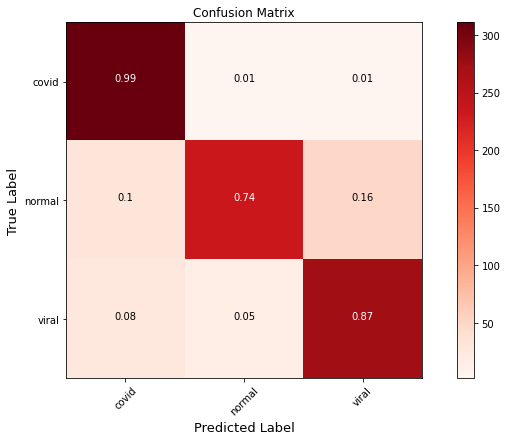

In [22]:
print('Confusion Matrix')
cm = confusion_matrix(test_set.classes, y_pred)
plot_confusion_matrix(cm, target_names, title = 'Confusion Matrix')

In [23]:
print('                      Classification Report')
print()
print(classification_report(test_set.classes, y_pred, target_names = target_names))

                      Classification Report

              precision    recall  f1-score   support

       covid       0.84      0.99      0.91       315
      normal       0.93      0.74      0.83       315
       viral       0.84      0.87      0.86       315

    accuracy                           0.87       945
   macro avg       0.87      0.87      0.86       945
weighted avg       0.87      0.87      0.86       945

